#IMPORT NECESSARY LIBRARIES

In [6]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

time: 9.22 ms (started: 2024-08-12 14:46:10 +00:00)


In [7]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

time: 1.09 ms (started: 2024-08-12 14:46:11 +00:00)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

time: 1.22 ms (started: 2024-08-12 14:46:11 +00:00)


##Define runtime

In [9]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.85 s (started: 2024-08-12 14:46:11 +00:00)


##Define GPU usage

In [10]:
# Define the device
print(torch.cuda.is_available(), " - ", torch.cuda.get_device_name(0))

# Set the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Change the index for each file (0 to 7)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device index and name
device_index = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(device_index)
print(f"Using device index: {device_index}, device name: {device_name}")

time: 1.92 ms (started: 2024-08-12 14:46:15 +00:00)


#DATA PREPARATION

##Get and Import dataset

In [11]:
# !gdown "1Ebju7n2W8WoWSFSPouDfbJcaW47Nozgv"
# !unzip "/content/ISIC_2019_Challenge_Dataset.zip"

time: 325 µs (started: 2024-08-12 14:46:15 +00:00)


In [12]:
# !gdown "1b-NZohmAAwhtZ-81EIt5bCI-c_3u-2jW"
# !gdown "1W3PE0W183h0nXW4ISSzW_aMZ4MWuDwhx"
# !gdown "1DQdofCumMkc8oGiHePB0sdMLMopXfvx-"
# !gdown "1FRM1CPVjVFxWLbZh242NTzR8L662DQ2e"
# !gdown "1T24VIj4GGyKv_ioSuOlz1zp08emXKXXE"

time: 294 µs (started: 2024-08-12 14:46:15 +00:00)


In [13]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MASTER 1/Internship/ICT Lab/WORKSPACE/data/ISIC_2019/'
# data_dir = '/content'
# data_dir = '/content/drive/MyDrive/WORKSPACE/data/ISIC_2019'
# data_dir = '/content/drive/MyDrive/Study Documents/MASTER Drive/MASTER 1/Internship/ICT Lab/WORKSPACE/data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

Mounted at /content/drive
time: 37.8 s (started: 2024-08-12 14:46:15 +00:00)


###Meta-data

In [14]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 2.4 s (started: 2024-08-12 14:46:53 +00:00)


In [15]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 548 ms (started: 2024-08-12 14:46:55 +00:00)


In [16]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 561 ms (started: 2024-08-12 14:46:56 +00:00)


###Meta-data information

In [17]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 91.6 ms (started: 2024-08-12 14:46:56 +00:00)


In [18]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 29.6 ms (started: 2024-08-12 14:46:56 +00:00)


In [19]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 10.8 ms (started: 2024-08-12 14:46:56 +00:00)


In [20]:
def print_unique_counts(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    unique_counts = df.nunique()
    print("\nUnique entries in each column:")
    for col in unique_counts.index:
        print(f"- {col}: {unique_counts[col]}")

# Now use the function for each dataframe
print_unique_counts(train_metadata, 'Train Metadata')
print_unique_counts(train_groundtruth, 'Train Groundtruth')
print_unique_counts(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Unique entries in each column:
- image: 25331
- age_approx: 18
- anatom_site_general: 8
- lesion_id: 11847
- sex: 2

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Unique entries in each column:
- image: 25331
- MEL: 2
- NV: 2
- BCC: 2
- AK: 2
- BKL: 2
- DF: 2
- VASC: 2
- SCC: 2
- UNK: 1

----------------------------------------
TEST METADATA
----------------------------------------

Unique entries in each column:
- image: 8238
- age_approx: 18
- anatom_site_general: 7
- sex: 2
time: 59.2 ms (started: 2024-08-12 14:46:56 +00:00)


In [21]:
# train_metadata['anatom_site_general'].unique()

time: 370 µs (started: 2024-08-12 14:46:56 +00:00)


##Data Analysis

###Meta-data describe

In [ ]:
def describe_and_check_nulls(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    print("\nDescription:")
    print(df.describe(include='all'))

    print("\nNull Values:")
    null_values = df.isnull().sum()
    print(null_values)

    print("\nPercentage of Null Values:")
    print(null_values / len(df) * 100)

# Now use the function for each dataframe
describe_and_check_nulls(train_metadata, 'Train Metadata')
describe_and_check_nulls(train_groundtruth, 'Train Groundtruth')
describe_and_check_nulls(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Description:
               image    age_approx anatom_site_general    lesion_id    sex
count          25331  24894.000000               22700        23247  24947
unique         25331           NaN                   8        11847      2
top     ISIC_0000000           NaN      anterior torso  BCN_0001728   male
freq               1           NaN                6915           31  13286
mean             NaN     54.028481                 NaN          NaN    NaN
std              NaN     18.130971                 NaN          NaN    NaN
min              NaN      0.000000                 NaN          NaN    NaN
25%              NaN     40.000000                 NaN          NaN    NaN
50%              NaN     55.000000                 NaN          NaN    NaN
75%              NaN     70.000000                 NaN          NaN    NaN
max              NaN     85.000000                 NaN         

In [ ]:
# train_metadata.describe(include='all')
# train_groundtruth.describe(include='all')
# test_metadata.describe(include='all')

# print("\ntrain_metadata")
# print(train_metadata.isnull().sum())
# print("\ntrain_groundtruth")
# print(train_groundtruth.isnull().sum())
# print("\ntest_metadata")
# print(test_metadata.isnull().sum())

time: 479 µs (started: 2024-08-03 16:36:56 +00:00)


###Plot data

####Define and describe meta-data's columns

In [ ]:
# List of dataframes
dfs = [train_metadata, train_groundtruth, test_metadata]
df_names = ['train_metadata', 'train_groundtruth', 'test_metadata']

time: 862 µs (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image', 'anatom_site_general', 'sex']
numerical_columns = ['age_approx']


time: 694 µs (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Describe each dataframe
def describe_columns(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print("\nNumerical Columns:")
    for col in numerical_cols:
        print(f"- {col}")

    print("\nCategorical Columns:")
    for col in categorical_cols:
        print(f"- {col}")

# Describe each dataframe
describe_columns(train_metadata, 'Train Metadata')
describe_columns(train_groundtruth, 'Train Groundtruth')
describe_columns(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- lesion_id
- sex

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Numerical Columns:
- MEL
- NV
- BCC
- AK
- BKL
- DF
- VASC
- SCC
- UNK

Categorical Columns:
- image

----------------------------------------
TEST METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- sex
time: 63.6 ms (started: 2024-08-03 16:36:57 +00:00)


####Missing values

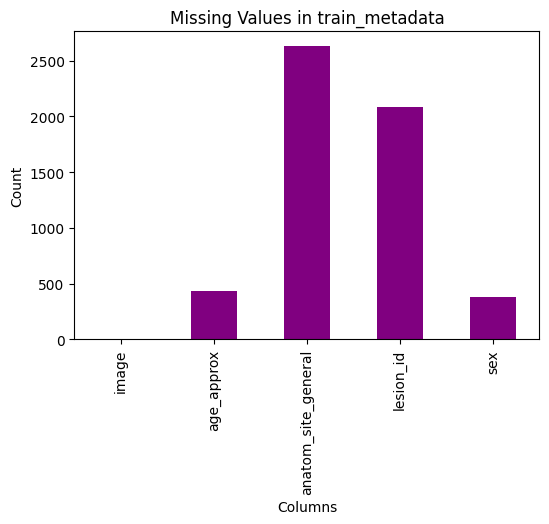

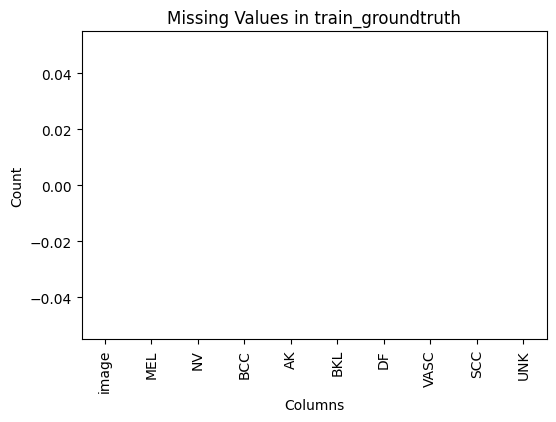

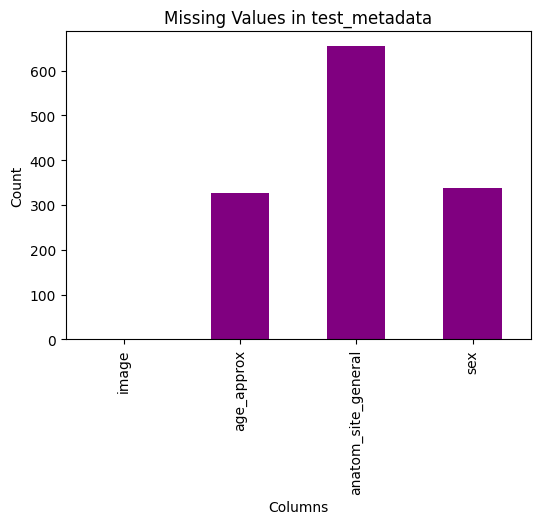

time: 3.37 s (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Loop through dataframes
for i, df in enumerate(dfs):
    # Calculate missing values
    missing_values = df.isnull().sum()

    # Plot missing values
    plt.figure(figsize=(6, 4))
    missing_values.plot(kind='bar', color='purple')
    plt.title('Missing Values in ' + df_names[i])
    plt.ylabel('Count')
    plt.xlabel('Columns')
    plt.show()


####Training-Metadata distribution

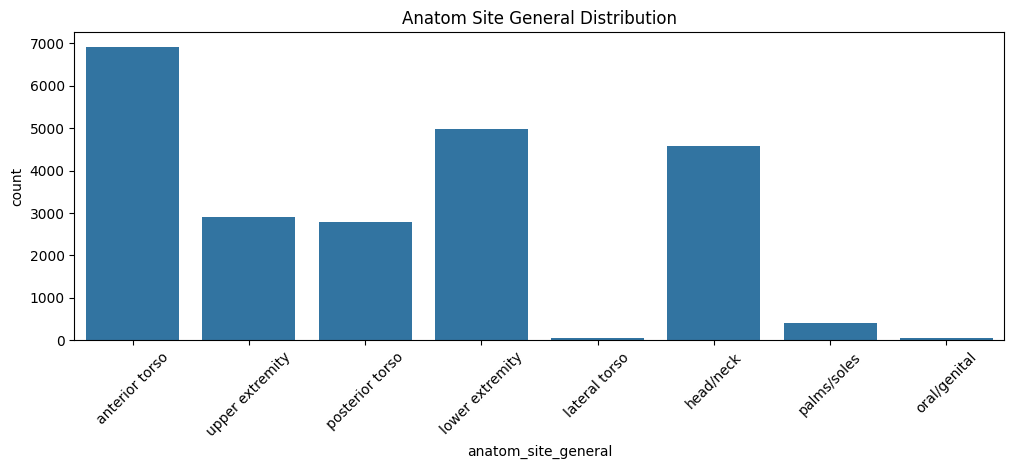

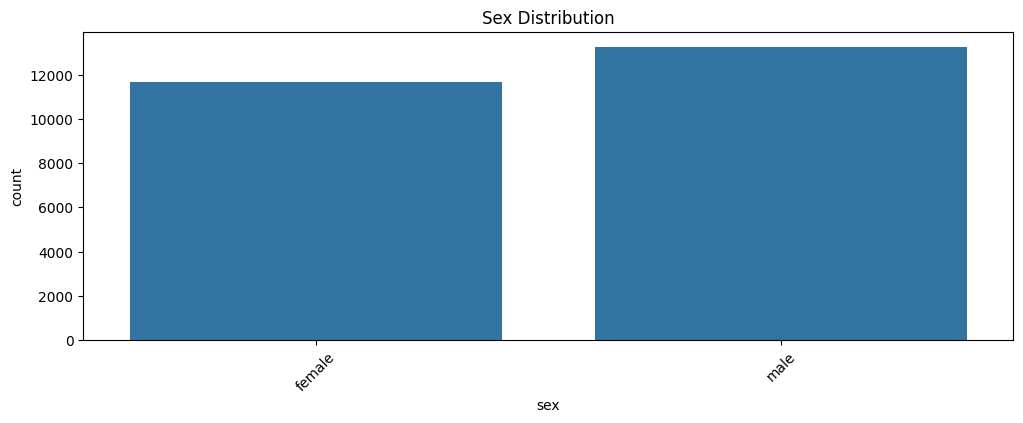

time: 2.54 s (started: 2024-08-03 16:37:00 +00:00)


In [ ]:
# Function to plot value counts for a given column
def plot_value_counts(data, column, title, figsize=(12, 4), rotation=45):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=column)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

# List of categorical columns to plot
categorical_columns_grt = ['anatom_site_general', 'sex']
# categorical_columns_grt = ['anatom_site_general', 'sex', 'lesion_id', 'image']

# Plot value counts for each categorical column
for column in categorical_columns_grt:
    plot_value_counts(train_metadata, column, f'{column.replace("_", " ").title()} Distribution')

# Plot value counts for lesion_id and image if needed
# plot_value_counts(train_metadata, 'lesion_id', 'Lesion ID Distribution', figsize=(16, 4))
# plot_value_counts(train_metadata, 'image', 'Image Name Distribution', figsize=(16, 4))

####Training_Groundtruth distribution

<ipython-input-22-57af30f33fcc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')


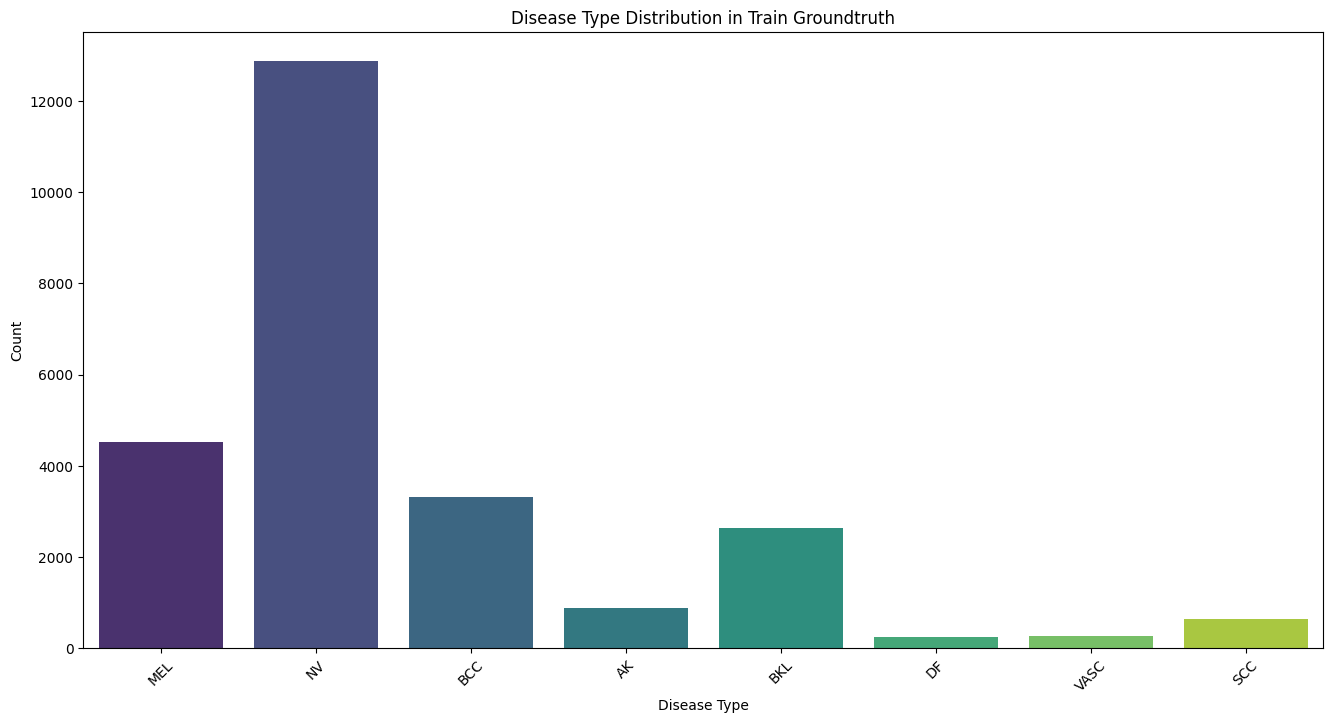

time: 1.64 s (started: 2024-08-03 16:37:03 +00:00)


In [ ]:
# Define columns to plot (excluding 'image' and 'UNK')
disease_type = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Sum up the counts of each class
disease_type_counts = train_groundtruth[disease_type].sum()

# Convert to DataFrame for easier plotting
disease_type_counts_df = pd.DataFrame(disease_type_counts).reset_index()
disease_type_counts_df.columns = ['Disease Type', 'Count']

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')
plt.title('Disease Type Distribution in Train Groundtruth')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


###Data Analysis for Relationship among variables

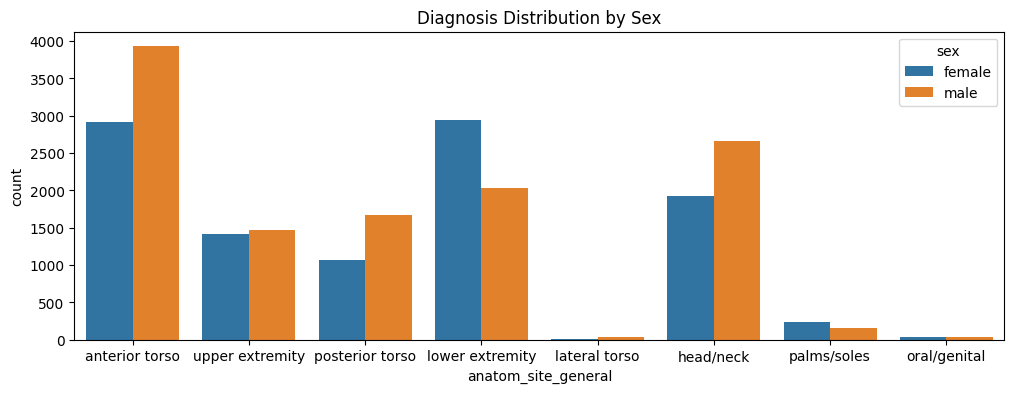

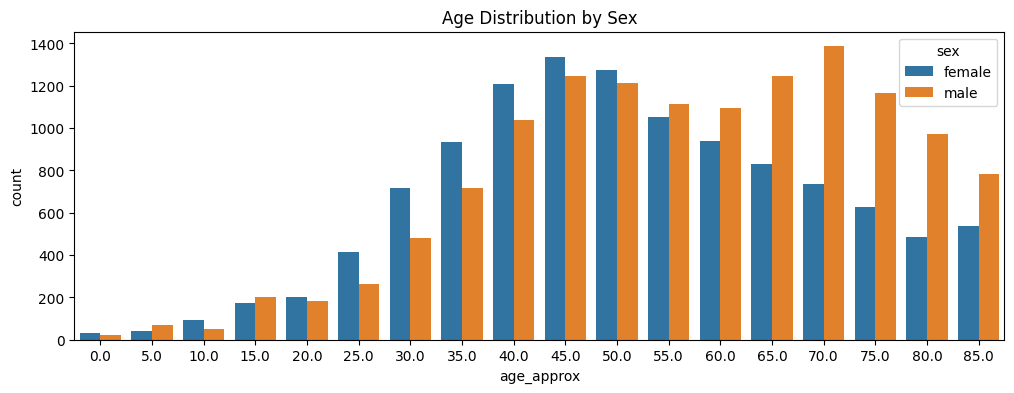

time: 4.38 s (started: 2024-08-03 16:37:04 +00:00)


In [ ]:
# Visualizing relationships between anatom_site_general and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='anatom_site_general', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

# Visualizing relationships between age_approx and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

In [ ]:
# Merge the metadata and groundtruth dataframes on the 'image' column
combined_df = pd.merge(train_metadata, train_groundtruth, on='image')

# Melt the dataframe to have disease types as a single column
melted_df = pd.melt(combined_df, id_vars=['image', 'sex', 'age_approx', 'anatom_site_general'], value_vars=disease_type)

# Filter out rows where value is 0 (i.e., the disease type is not present)
filtered_df = melted_df[melted_df['value'] == 1]

time: 257 ms (started: 2024-08-03 16:37:09 +00:00)


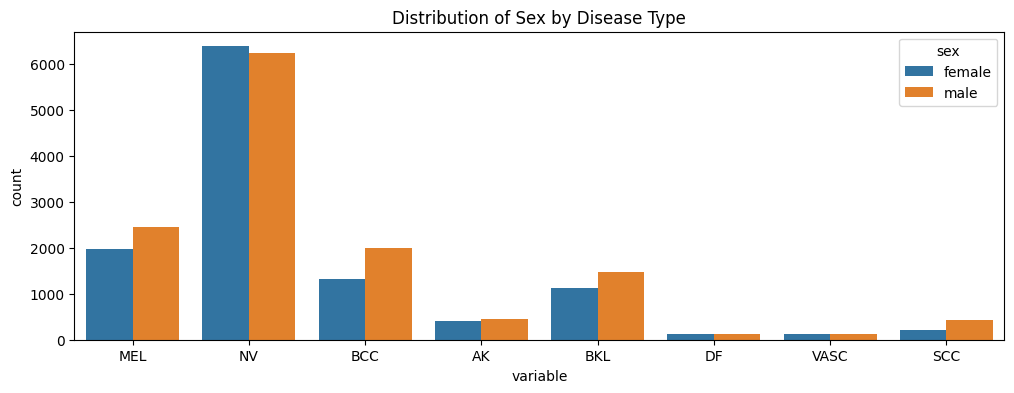

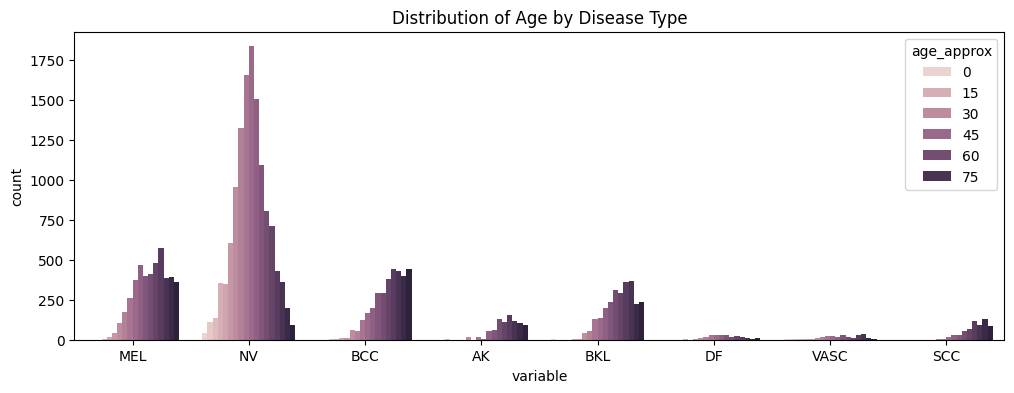

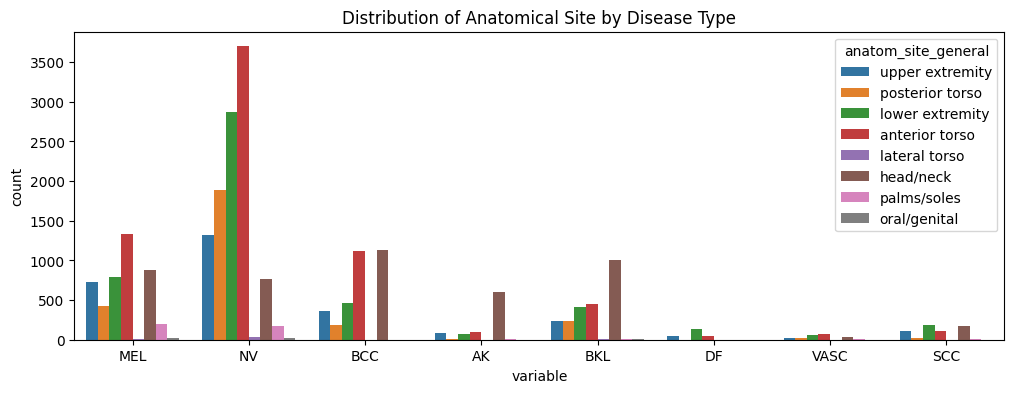

time: 5.39 s (started: 2024-08-03 16:37:09 +00:00)


In [ ]:
# Plot the distribution of 'sex' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='sex')
plt.title('Distribution of Sex by Disease Type')
plt.show()

# Plot the distribution of 'age_approx' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='age_approx')
plt.title('Distribution of Age by Disease Type')
plt.show()

# Plot the distribution of 'anatom_site_general' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='anatom_site_general')
plt.title('Distribution of Anatomical Site by Disease Type')
plt.show()

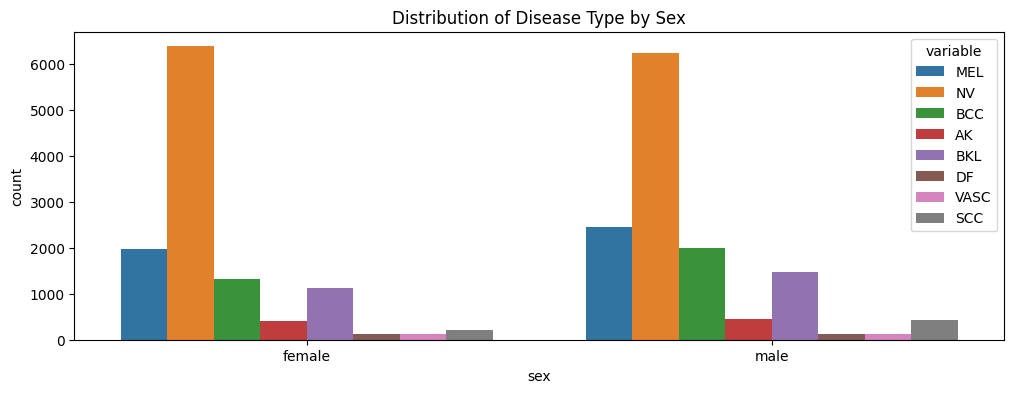

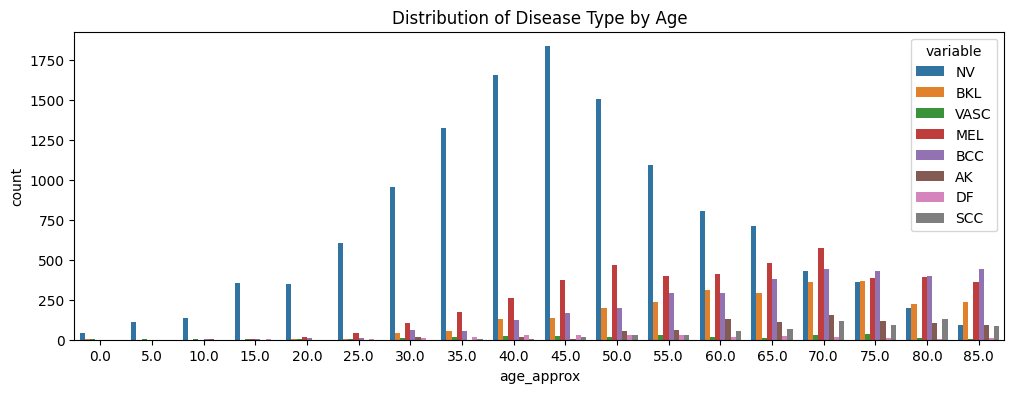

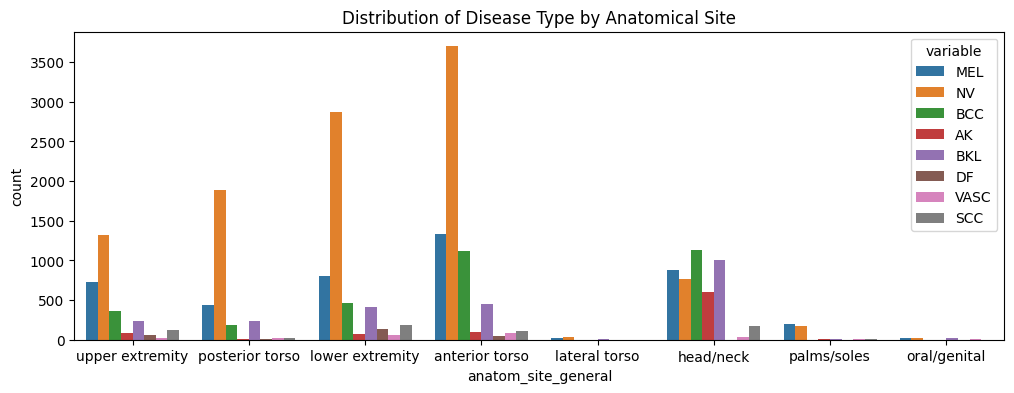

time: 4.16 s (started: 2024-08-03 16:37:14 +00:00)


In [ ]:
# Plot the distribution of disease type by 'sex'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='sex', hue='variable')
plt.title('Distribution of Disease Type by Sex')
plt.show()

# Plot the distribution of disease type by 'age_approx'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='age_approx', hue='variable')
plt.title('Distribution of Disease Type by Age')
plt.show()

# Plot the distribution of disease type by 'anatom_site_general'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='anatom_site_general', hue='variable')
plt.title('Distribution of Disease Type by Anatomical Site')
plt.show()


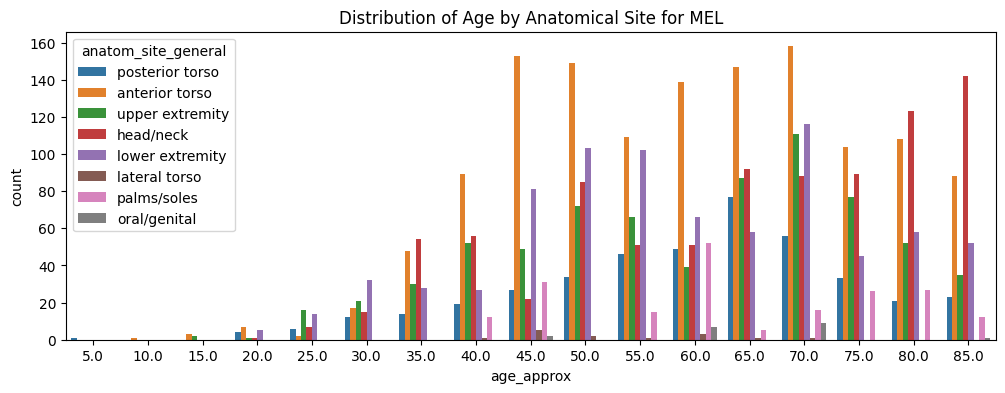

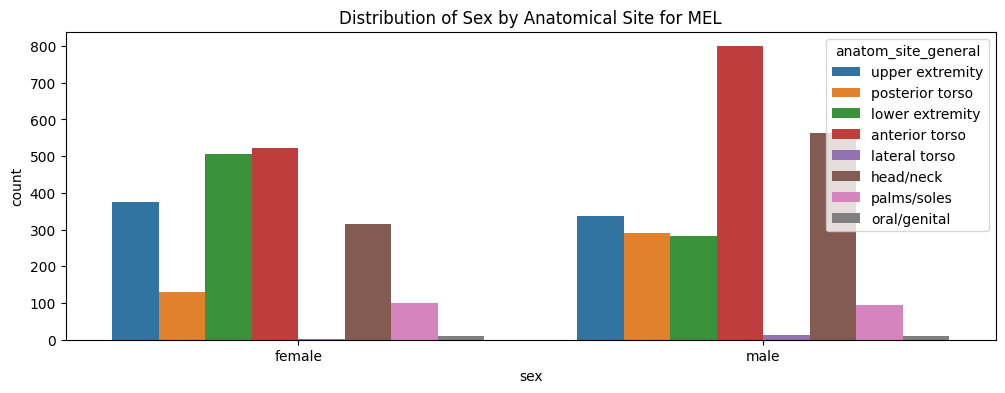

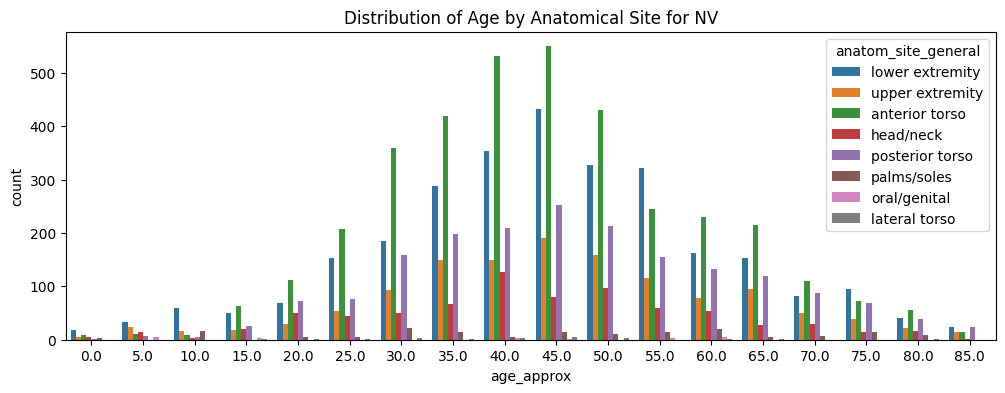

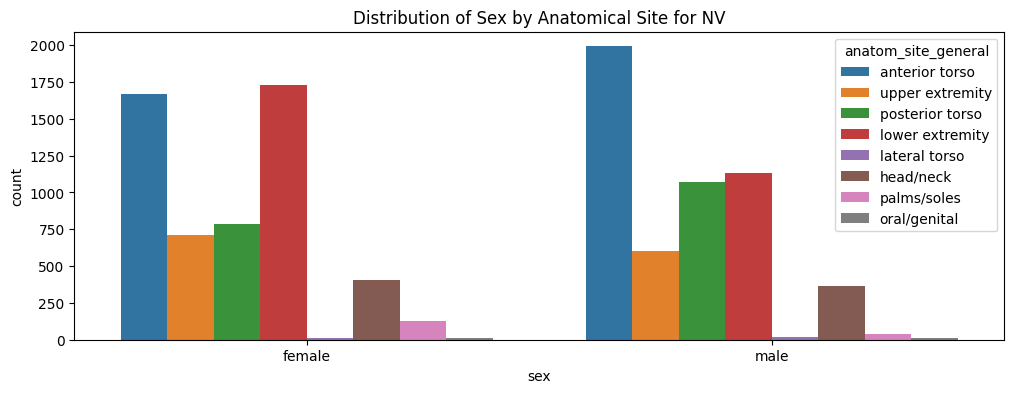

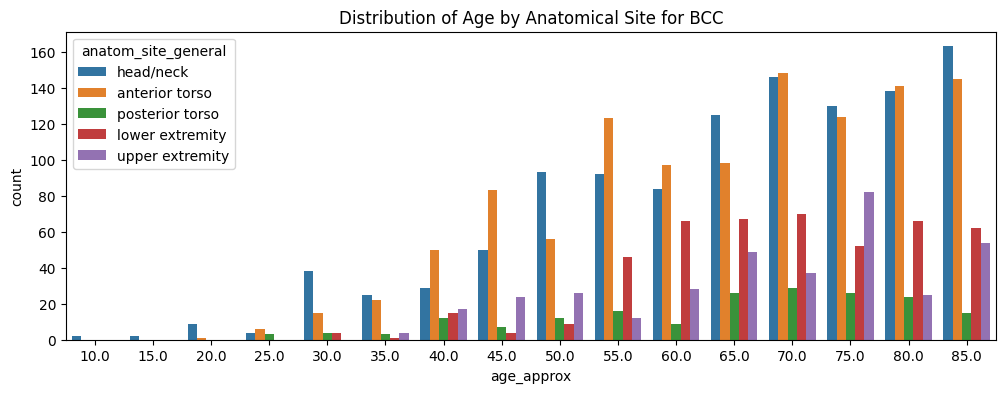

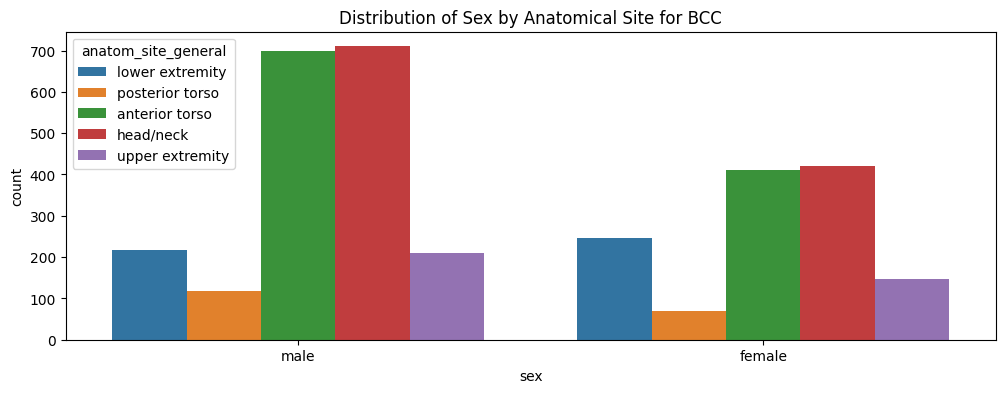

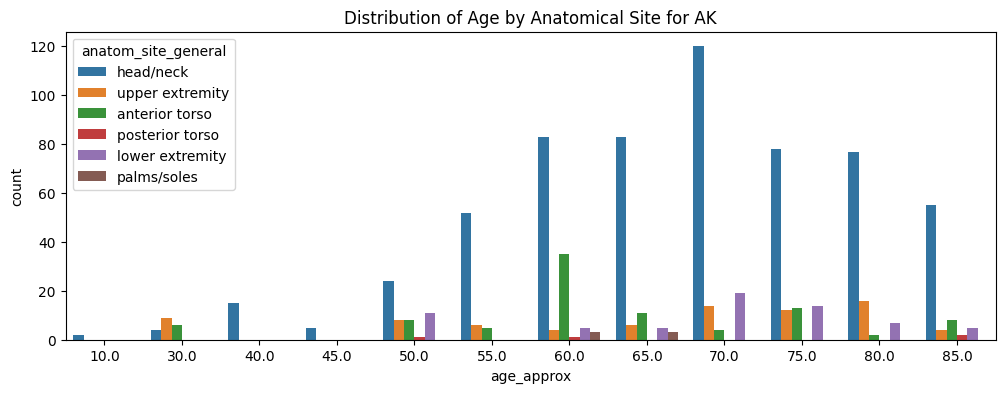

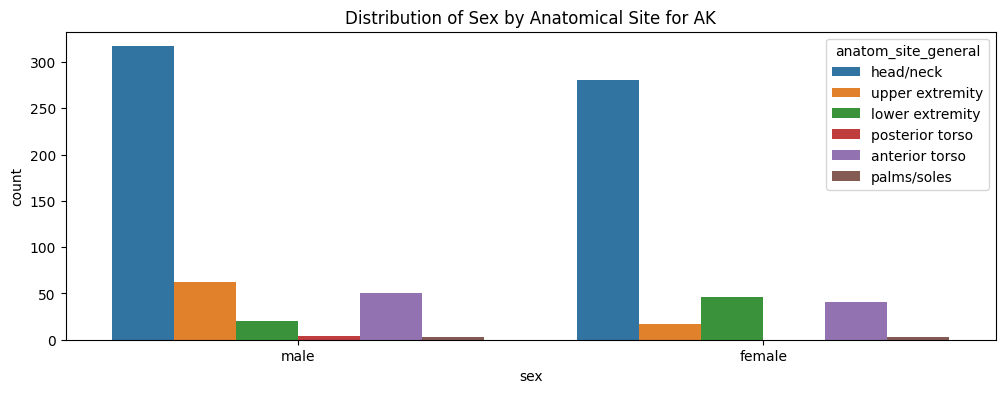

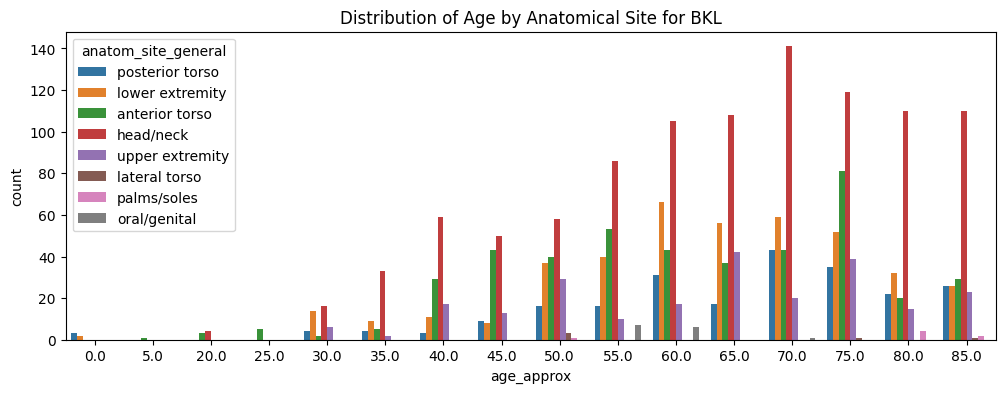

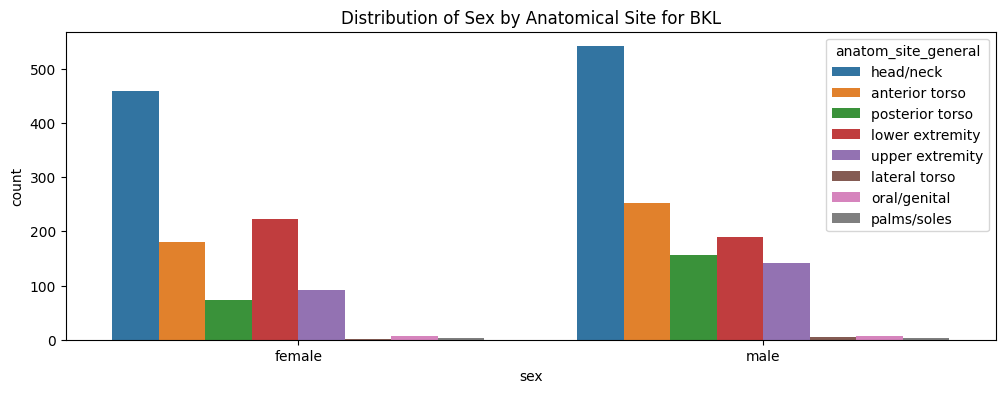

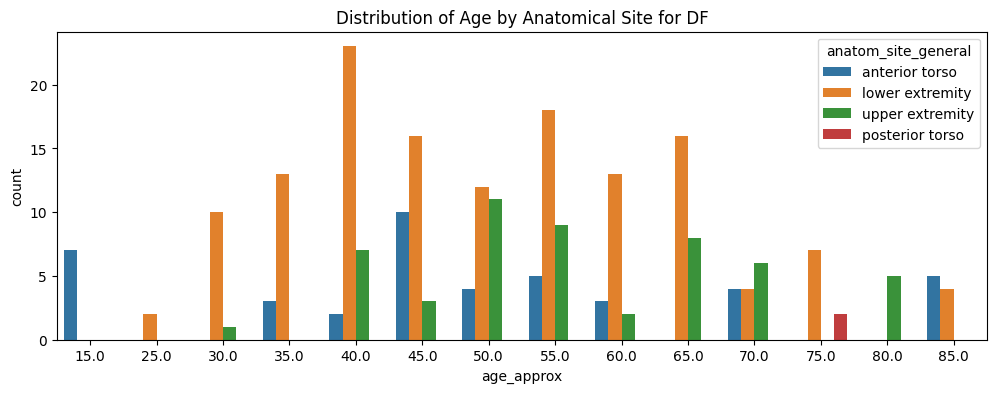

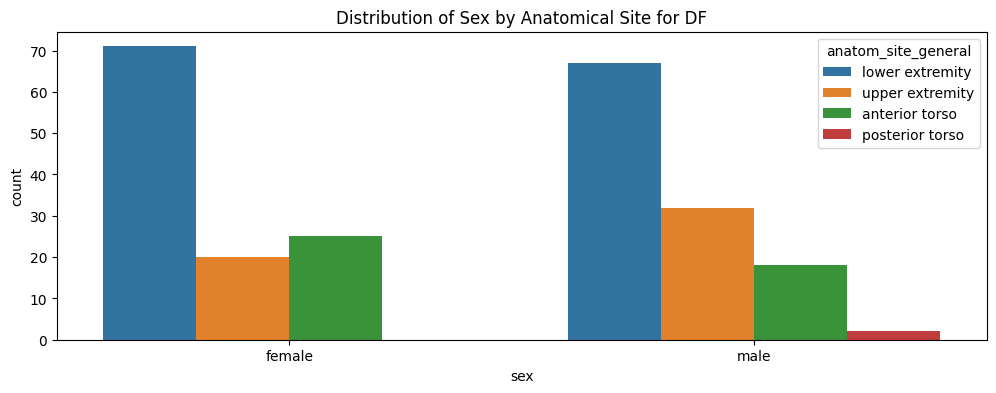

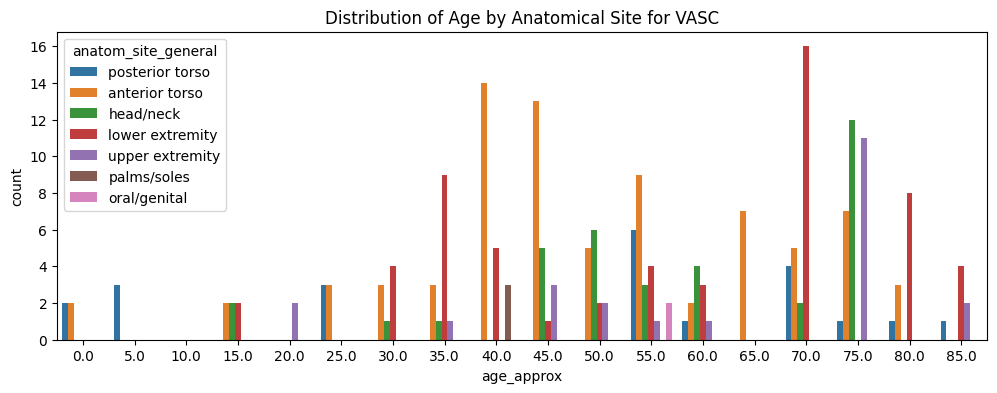

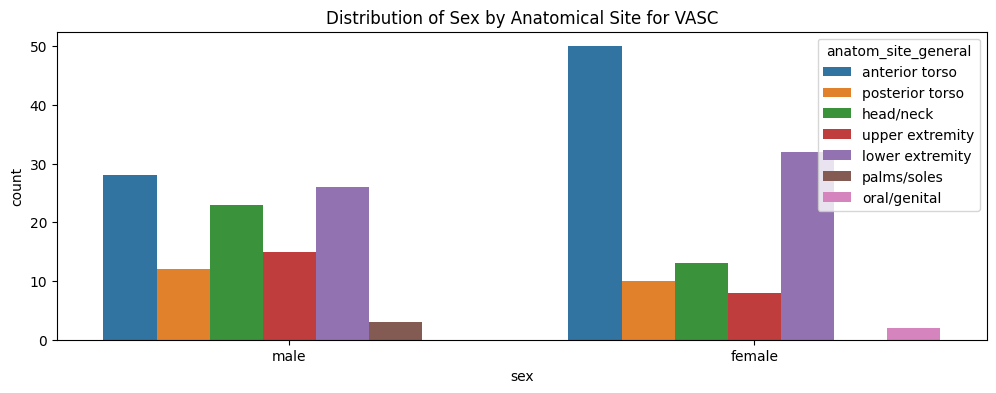

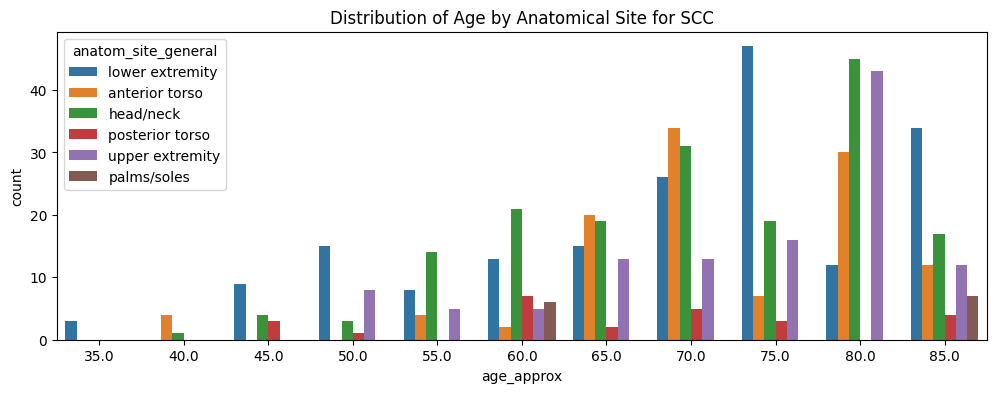

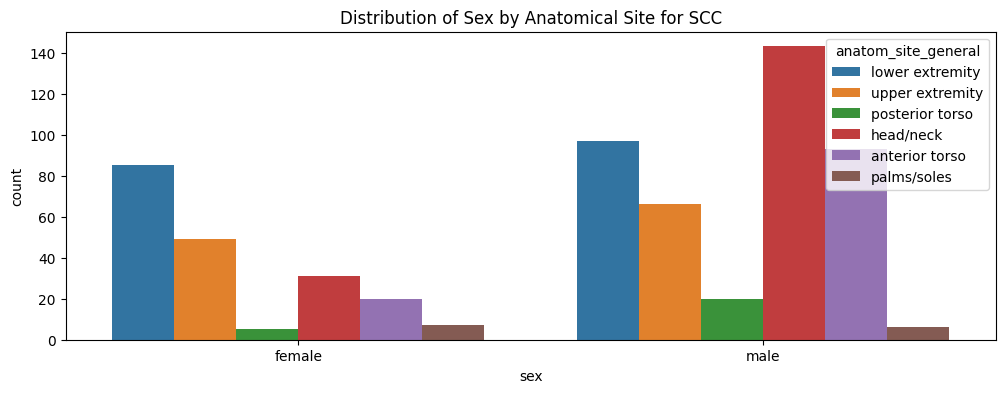

time: 22.5 s (started: 2024-08-03 16:37:19 +00:00)


In [ ]:
# Loop through each disease type
for disease in disease_type:
    # Create a subset of the dataframe for the current disease type
    subset_df = combined_df[combined_df[disease] == 1]

    # Plot the distribution of 'age_approx' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='age_approx', hue='anatom_site_general')
    plt.title(f'Distribution of Age by Anatomical Site for {disease}')
    plt.show()

    # Plot the distribution of 'sex' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='sex', hue='anatom_site_general')
    plt.title(f'Distribution of Sex by Anatomical Site for {disease}')
    plt.show()


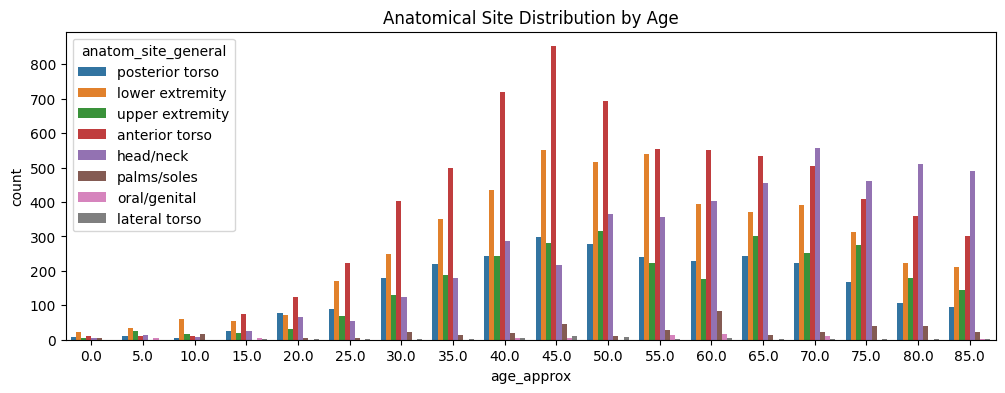

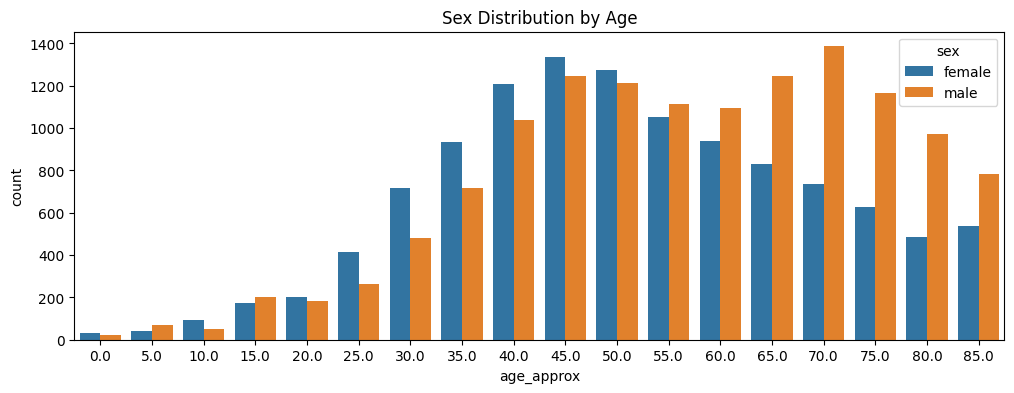

time: 1.47 s (started: 2024-08-03 16:37:41 +00:00)


In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='anatom_site_general')
plt.title('Anatomical Site Distribution by Age')
plt.show()

# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Sex Distribution by Age')
plt.show()

##DATA PREPROCESSING

###Original data information

In [22]:
train_metadata.info()
print()
train_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB



,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


time: 117 ms (started: 2024-08-12 14:46:57 +00:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [23]:
print(train_metadata.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 2.45 ms (started: 2024-08-12 14:46:57 +00:00)


In [24]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 116 ms (started: 2024-08-12 14:46:57 +00:00)


In [25]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 85.2 ms (started: 2024-08-12 14:46:57 +00:00)


In [26]:
for col in train_metadata_pp.columns:
  print(f'{col}: {train_metadata_pp[col].unique()}\n')

Image_Id: ['ISIC_0012653_downsampled' 'ISIC_0012654_downsampled'
 'ISIC_0012655_downsampled' ... 'ISIC_0073249' 'ISIC_0073251'
 'ISIC_0073254']

Age: [50 30 35 45 20 40 75 25 70 60 55 65 80 85 15 10  5  0]

Region_Of_Disease: ['posterior torso' 'lower extremity' 'upper extremity' 'head/neck'
 'anterior torso' 'lateral torso' 'palms/soles' 'oral/genital']

Lesion_Id: ['MSK4_0011169' 'MSK4_0011170' 'MSK4_0011171' ... 'BCN_0002147'
 'BCN_0001946' 'BCN_0001014']

Sex: ['female' 'male']

Disease_Type: ['NV' 'BKL' 'MEL' 'DF' 'SCC' 'BCC' 'VASC' 'AK']

Presence: [1.]

Diagnosis: ['Melanocytic Nevi' 'Benign Keratosis-Like Lesions' 'Melanoma'
 'Dermatofibroma' 'Squamous Cell Carcinoma' 'Basal Cell Carcinoma'
 'Vascular Lesions' 'Actinic Keratoses']

time: 38 ms (started: 2024-08-12 14:46:57 +00:00)


In [27]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 198 ms (started: 2024-08-12 14:46:57 +00:00)


###Get images data

finish preprocessing

In [29]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...


time: 2.38 s (started: 2024-08-12 14:49:18 +00:00)


In [30]:
train_metadata_pp = train_metadata_pp.sample(n=1000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 19360 to 14354
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           1000 non-null   object 
 1   Age                1000 non-null   int64  
 2   Region_Of_Disease  1000 non-null   object 
 3   Lesion_Id          1000 non-null   object 
 4   Sex                1000 non-null   object 
 5   Disease_Type       1000 non-null   object 
 6   Presence           1000 non-null   float64
 7   Diagnosis          1000 non-null   object 
 8   Image_path         1000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 78.1+ KB
time: 11.9 ms (started: 2024-08-12 14:49:20 +00:00)


###Correctting image paths

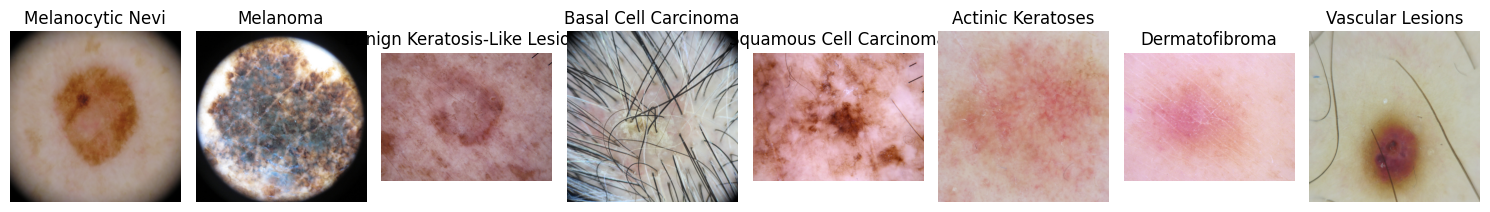

time: 17.7 s (started: 2024-08-12 14:49:20 +00:00)


In [31]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 3.03 ms (started: 2024-08-12 14:51:01 +00:00)


###Augment and transfrom dataset

In [33]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 2.34 ms (started: 2024-08-12 14:51:01 +00:00)


###Split data

In [34]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 800
Validation set size: 100
Test set size: 100
time: 9.03 ms (started: 2024-08-12 14:51:01 +00:00)


###Balancing dataset

In [35]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 2912
time: 13.6 ms (started: 2024-08-12 14:51:01 +00:00)


###Custom dataset class

In [36]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([1, 7, 7, 5, 4, 4, 3, 2, 7, 3, 3, 2, 5, 0, 5, 1, 2, 4, 6, 2, 5, 6, 4, 4,
        7, 5, 6, 5, 1, 1, 0, 3])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 5 2 1 6 0 3 7]
time: 24.2 s (started: 2024-08-12 14:51:01 +00:00)


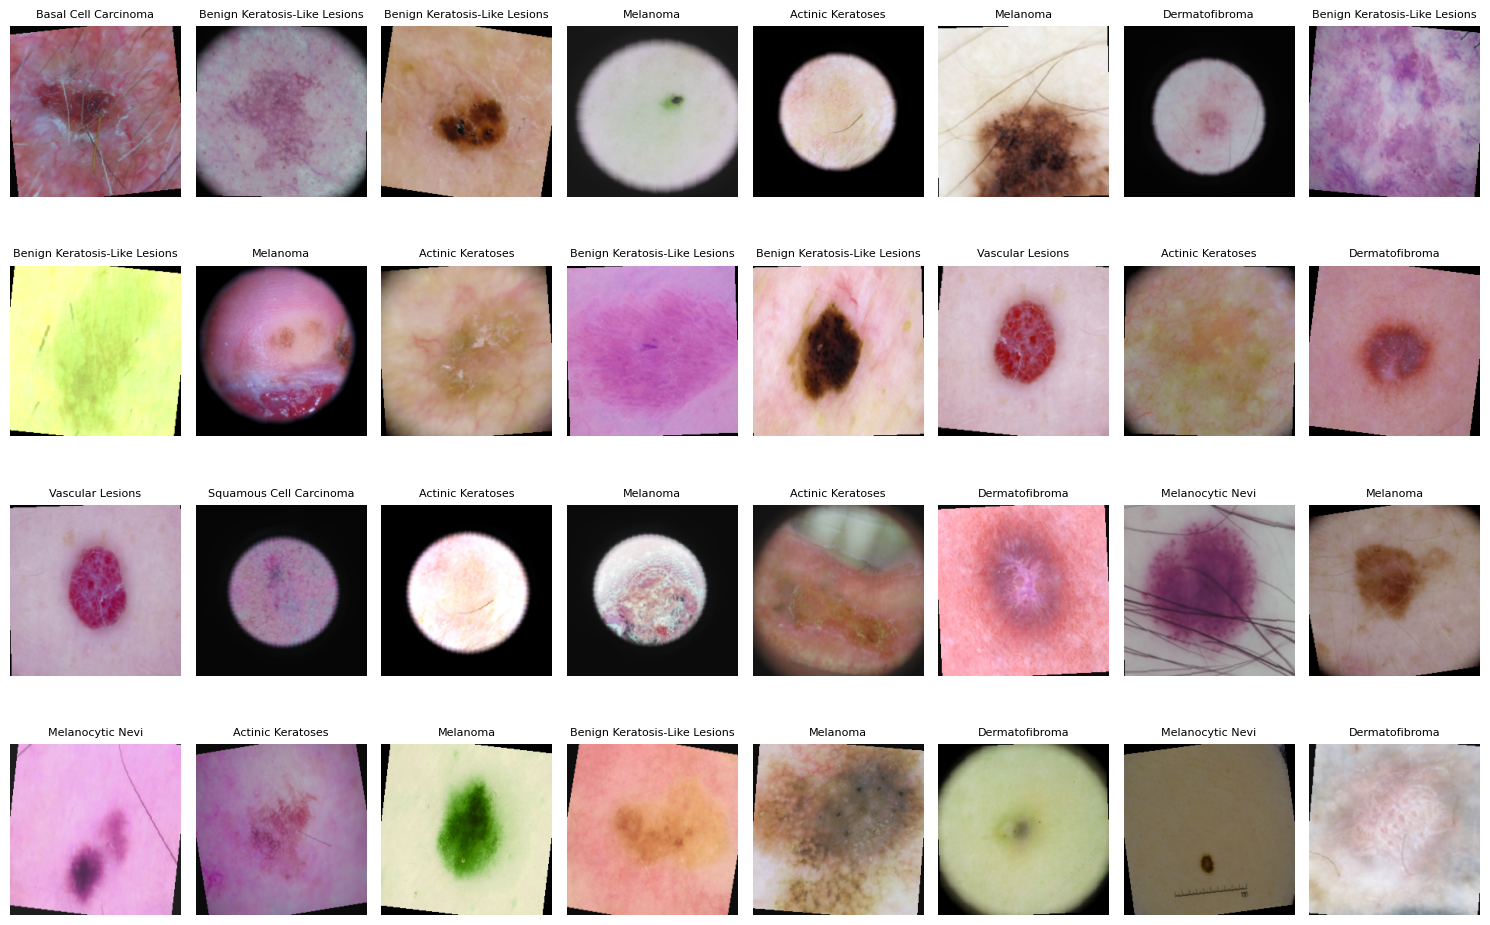

time: 21 s (started: 2024-08-12 14:51:25 +00:00)


In [37]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        # label_name = label_mapping.get(label, "Unknown")  # Handle potential mismatches
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)

##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [38]:
# Define pre-trained model
def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b5(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'nasnetmobile': # NO NASNETMOBILE IN TORCH
        model = models.nasnetamobile(pretrained=True)
        num_ftrs = model.last_linear.in_features
        model.last_linear = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnext50':
        model = models.resnext50_32x4d(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'squeezenet':
        model = models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
    elif model_name == 'customCNN':
        model = CustomCNN(num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50v2', 'efficientnet', 'densenet', 'mobilenetv2', 'nasnetmobile', 'resnext50', 'squeezenet', or 'customCNN'.")
    return model


time: 1.19 ms (started: 2024-08-12 14:52:53 +00:00)


####Custom model

In [39]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

time: 1.89 ms (started: 2024-08-12 14:52:54 +00:00)


###Training activities

In [40]:
# Training function with early stopping and metrics storage
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_loss = np.inf
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward() # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            metrics['Train Loss'] = f'{train_loss:.4f}'
            metrics['Train Accuracy'] = f'{train_acc:.2f}%'

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc = validate_model(model, val_loader, criterion)

                metrics['Val Loss'] = f'{val_loss:.4f}'
                metrics['Val Accuracy'] = f'{val_acc:.2f}%'

                progress_bar.set_postfix(metrics)
                progress_bar.refresh()
            else:
                progress_bar.set_postfix(metrics)

        val_loss, val_acc = validate_model(model, val_loader, criterion)

        # Update the progress bar with validation metrics after each epoch
        metrics['Val Loss'] = f'{val_loss:.4f}'
        metrics['Val Accuracy'] = f'{val_acc:.2f}%'

        # Store metrics for plotting
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return metrics


time: 1.59 ms (started: 2024-08-12 14:52:55 +00:00)


In [79]:
# Training function with early stopping and metrics storage
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_loss = np.inf
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward() # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc = validate_model(model, val_loader, criterion)

                metrics['Train Loss'].append(train_loss)
                metrics['Train Accuracy'].append(train_acc)
                metrics['Val Loss'].append(val_loss)
                metrics['Val Accuracy'].append(val_acc)

                progress_bar.set_postfix({
                    'Train Loss': f'{train_loss:.4f}',
                    'Train Accuracy': f'{train_acc:.2f}%',
                    'Val Loss': f'{val_loss:.4f}',
                    'Val Accuracy': f'{val_acc:.2f}%'
                })
                progress_bar.refresh()
            else:
                progress_bar.set_postfix({
                    'Train Loss': f'{train_loss:.4f}',
                    'Train Accuracy': f'{train_acc:.2f}%',
                    'Val Loss': f'{metrics["Val Loss"][-1]:.4f}' if metrics['Val Loss'] else '[]',
                    'Val Accuracy': f'{metrics["Val Accuracy"][-1]:.2f}%' if metrics['Val Accuracy'] else '[]'
                })

        val_loss, val_acc = validate_model(model, val_loader, criterion)

        # Update the progress bar with validation metrics after each epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return metrics


time: 16.3 ms (started: 2024-08-12 08:56:47 +00:00)


In [41]:
# Training function with early stopping and metrics storage
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_loss = np.inf
    patience_counter = 0
    metrics = {
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Loss': [],
        'Val Accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=200)  # Adjust ncols to set the width
        num_batches = len(train_loader)
        validate_every_n_batches = max(1, num_batches // 10)  # Calculate the number of batches for 10% progress

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward() # Backpropagation
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loss = running_loss / (batch_idx + 1)
            train_acc = 100 * correct / total

            if (batch_idx + 1) % validate_every_n_batches == 0 or (batch_idx + 1) == num_batches:
                val_loss, val_acc = validate_model(model, val_loader, criterion)

                progress_bar.set_postfix({
                    'Train Loss': f'{train_loss:.4f}',
                    'Train Accuracy': f'{train_acc:.2f}%',
                    'Val Loss': f'{val_loss:.4f}',
                    'Val Accuracy': f'{val_acc:.2f}%'
                })
                progress_bar.refresh()
            else:
                progress_bar.set_postfix({
                    'Train Loss': f'{train_loss:.4f}',
                    'Train Accuracy': f'{train_acc:.2f}%',
                    'Val Loss': '[]',
                    'Val Accuracy': '[]'
                })

        val_loss, val_acc = validate_model(model, val_loader, criterion)

        # Store final metrics for the epoch
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_acc)
        metrics['Val Loss'].append(val_loss)
        metrics['Val Accuracy'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return metrics


time: 3.64 ms (started: 2024-08-12 14:53:09 +00:00)


In [42]:
# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc

time: 1.09 ms (started: 2024-08-12 14:53:15 +00:00)


###Visualize training result

In [43]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['Train Loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['Train Loss'], label='Train Loss')
    plt.plot(epochs, metrics['Val Loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['Train Accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['Val Accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

time: 824 µs (started: 2024-08-12 14:54:11 +00:00)


##Train the model

###Test training


In [ ]:
# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Configuration for training process

model_name = 'resnet50v2'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

num_classes = len(label_mapping)

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # transfer learning model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


time: 2.57 s (started: 2024-08-04 11:36:57 +00:00)


In [ ]:
# Start training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 10/10: 100%|██████████| 457/457 [12:00<00:00,  1.58s/it, Train Loss=1.5099, Train Accuracy=41.61%, Val Loss=1.6068, Val Accuracy=37.60%]


time: 2h 2min 51s (started: 2024-08-04 11:37:09 +00:00)


CNN MODEL

In [ ]:
# Configuration for training process

model_name = 'customCNN'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

num_classes = len(label_mapping)

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # transfer learning model

time: 854 ms (started: 2024-08-05 07:15:22 +00:00)


In [ ]:
# Start training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 6/10: 100%|██████████| 457/457 [12:46<00:00,  1.68s/it, Train Loss=2.1491, Train Accuracy=12.50%, Val Loss=2.0764, Val Accuracy=19.40%]


Early stopping triggered
time: 1h 27min 6s (started: 2024-08-05 07:15:28 +00:00)


###Start training

In [ ]:
# Configuration for training process

num_classes = len(label_mapping)

model_name = 'densenet'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # transfer learning model

# Start training
num_epochs = 2
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 94.8MB/s]
Epoch 2/2:   7%|█████▎                                                                           | 6/91 [02:43<34:18, 24.21s/it, Train Loss=2.1862, Train Accuracy=23.96%, Val Loss

##Visualize training result

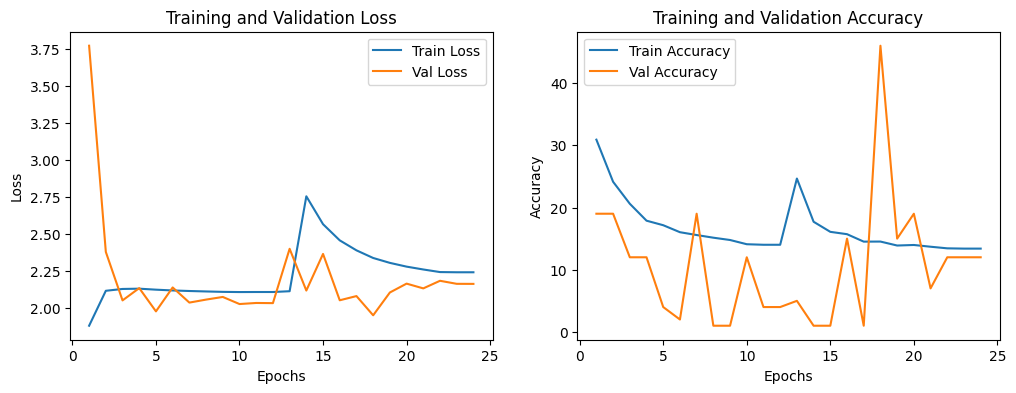

time: 392 ms (started: 2024-08-12 09:02:19 +00:00)


In [81]:
# Plot the metrics
plot_metrics(metrics)

##Save trained model

###Functionalities

In [ ]:
# def save_model(model, save_dir, save_model_name):
#     """
#     Save the trained model to the specified directory.

#     Parameters:
#     - model: The trained model to be saved.
#     - save_dir: The directory where the model should be saved.
#     - save_model_name: The name of the model file.

#     Returns:
#     - save_path: The full path where the model is saved.
#     """
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#         print(f"Directory '{save_dir}' created.")

#     save_path = os.path.join(save_dir, save_model_name)

#     # Check if the model name already exists
#     if os.path.exists(save_path):
#         user_input = input(f"The model '{save_model_name}' already exists. Enter 1 to overwrite it, or any other key to add a postfix: ")
#         if user_input != '1':
#             base_name, ext = os.path.splitext(save_model_name)
#             counter = 1
#             while os.path.exists(save_path):
#                 save_model_name = f"{base_name}_{counter}{ext}"
#                 save_path = os.path.join(save_dir, save_model_name)
#                 counter += 1

#     torch.save(model.state_dict(), save_path)
#     print(f"Model saved to {save_path}")
#     return save_path

# # Example usage:
# save_dir = '/content/drive/MyDrive/Models'
# save_model_name = 'efficientnet_model.pth'
# save_model(model, save_dir, save_model_name)


In [ ]:
def save_model(model, model_name, save_dir):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory '{save_dir}' created.")

    model_save_path = f'{save_dir}/{model_name}.pth'

    if os.path.exists(model_save_path):
        print(f"Model '{model_name}.pth' already exists.")
        print("Do you want to overwrite it? (1 for Yes, 0 for No): ", end='', flush=True)

        start_time = time.time()
        overwrite = None

        while True:
            if time.time() - start_time > 300:  # 5 minutes timeout
                print("\nNo input received. Saving model with a new name.")
                overwrite = '0'
                break

            if overwrite is None:
                overwrite = input()

            if overwrite == '1':
                torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, model_save_path)
                print(f"Model '{model_name}' overwritten and saved to {model_save_path}")
                return
            else:
                # Find a new name with an increasing number
                i = 1
                new_model_save_path = f'{save_dir}/{model_name}_{i}.pth'
                while os.path.exists(new_model_save_path):
                    i += 1
                    new_model_save_path = f'{save_dir}/{model_name}_{i}.pth'
                torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, new_model_save_path)
                print(f"Model saved to {new_model_save_path}")
                return
    else:
        torch.save({'model_name': model_name, 'state_dict': model.state_dict()}, model_save_path)
        print(f"Model saved to {model_save_path}")

time: 1.19 ms (started: 2024-08-09 07:05:52 +00:00)


###To save the trained model

In [ ]:
# Save the model
save_dir = '/content/saved_models'
# save_model_name = 'efficientnet'
save_model_name = model_name
save_model(model, save_model_name, save_dir)

Model 'densenet.pth' already exists.
Do you want to overwrite it? (1 for Yes, 0 for No): 
Model saved to /content/saved_models/densenet_1.pth
time: 1.93 s (started: 2024-08-09 07:09:57 +00:00)


#TEST THE MODELS

##Get saved model

###Functionalities

In [ ]:
def load_models(saved_dir, expected_num_classes, expected_model_name=None):
    models_dict = {}

    def get_base_model_name(model_name):
        return model_name.split('_')[0]

    if expected_model_name:
        # Load a specific model
        model_save_path = f'{saved_dir}/{expected_model_name}.pth'

        # Load the saved model and model name
        model_info = torch.load(model_save_path)
        loaded_model_name = model_info['model_name']

        if get_base_model_name(loaded_model_name) != get_base_model_name(expected_model_name):
            raise ValueError(f"Model name mismatch: expected {expected_model_name}, but got {loaded_model_name}")

        model = create_model(loaded_model_name, expected_num_classes)  # Make sure to create the model architecture first
        model.load_state_dict(model_info['state_dict'])
        model = model.to(device)  # Move the model to the device
        print(f"Model '{expected_model_name}' loaded successfully")

        models_dict[expected_model_name] = model
    else:
        # Load all models
        for filename in os.listdir(saved_dir):
            if filename.endswith('.pth'):
                model_name = os.path.splitext(filename)[0]
                model_save_path = os.path.join(saved_dir, filename)

                # Load the saved model and model name
                model_info = torch.load(model_save_path)
                loaded_model_name = model_info['model_name']

                if get_base_model_name(loaded_model_name) != get_base_model_name(model_name):
                    raise ValueError(f"Model name mismatch: expected {model_name}, but got {loaded_model_name}")

                model = create_model(loaded_model_name, expected_num_classes)  # Make sure to create the model architecture first
                model.load_state_dict(model_info['state_dict'])
                model = model.to(device)  # Move the model to the device
                print(f"Model '{model_name}' loaded successfully")

                models_dict[model_name] = model

    return models_dict

time: 1.18 ms (started: 2024-08-09 07:09:42 +00:00)


###Load model

In [ ]:
expected_num_classes = len(label_mapping)
saved_dir = '/content/saved_models'

time: 584 µs (started: 2024-08-09 07:09:45 +00:00)


In [ ]:
# To load a specific model
expected_model_name = 'densenet'
# expected_model_name = 'efficientnet_12'

models_dict = load_models(saved_dir, expected_num_classes, expected_model_name=expected_model_name)
specific_model = models_dict.get(expected_model_name)

Model 'densenet' loaded successfully
time: 418 ms (started: 2024-08-09 07:09:47 +00:00)


In [ ]:
# To load all models
models_dict = load_models(saved_dir, expected_num_classes)

Model 'densenet_1' loaded successfully
Model 'densenet' loaded successfully
time: 769 ms (started: 2024-08-09 07:10:04 +00:00)


##Apply model loaded for prediction

In [ ]:
# Assuming `specific_model` is the loaded model
specific_model.eval()  # Set the model to evaluation mode

# Example inference on a single image
image_path = '/content/ISIC_0034321.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Apply the same transformations and add batch dimension

image = image.to(device)
output = specific_model(image)
_, predicted = torch.max(output, 1)
print(f"Predicted label: {predicted.item()}")


Predicted label: 5
time: 55.5 ms (started: 2024-08-08 17:14:42 +00:00)
